In [1]:
from pyDeepInsight import ImageTransformer
import scanpy as sc
import os as os
import numpy as np
import pandas as pd
os.getcwd() # get current working directory
#os.chdir() # change working directory
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pickle
import anndata
import random
from timeit import default_timer as timer

/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
reference = sc.read_h5ad('./train_data/kinker_2020_SCP542.h5ad')

In [5]:
reference.obs.cell_type.value_counts()

cell_type
Lung Cancer                   12842
Head and Neck Cancer           7102
Skin Cancer                    5351
Breast Cancer                  3285
Brain Cancer                   2967
Esophageal Cancer              2544
Ovarian Cancer                 2495
Pancreatic Cancer              2368
Colon/Colorectal Cancer        2104
Endometrial/Uterine Cancer     2057
Kidney Cancer                  1561
Liver Cancer                   1550
Name: count, dtype: int64

In [4]:
reference = reference[reference.obs['cell_type'] != 'Gallbladder Cancer']
reference = reference[reference.obs['cell_type'] != 'Fibroblast']
reference = reference[reference.obs['cell_type'] != 'Prostate Cancer']
reference = reference[reference.obs['cell_type'] != 'Neuroblastoma']
reference = reference[reference.obs['cell_type'] != 'Thyroid Cancer']
reference = reference[reference.obs['cell_type'] != 'Sarcoma']
reference = reference[reference.obs['cell_type'] != 'Bone Cancer']
reference = reference[reference.obs['cell_type'] != 'Gastric Cancer']
reference = reference[reference.obs['cell_type'] != 'Bladder Cancer']
reference = reference[reference.obs['cell_type'] != 'Bile Duct Cancer']

In [6]:
#label mitochondrial gene
reference.var['mt'] =  reference.var.index.str.startswith('MT-')

#label ribosomal gene
ribo_url = "https://www.genenames.org/cgi-bin/genegroup/download?id=1054&type=branch"
ribo_gene = pd.read_table(ribo_url)
reference.var['ribo'] = reference.var_names.isin(ribo_gene["Approved symbol"].values)


sc.pp.calculate_qc_metrics(reference, qc_vars = ['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)
#visualize the QC
#sc.pl.violin(reference, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.6, multi_panel=True)
upper_lim = np.quantile(reference.obs.n_genes_by_counts.values, .99)
lower_lim = np.quantile(reference.obs.n_genes_by_counts.values, .01)
reference = reference[reference.obs.pct_counts_mt < 25]
reference = reference[reference.obs.n_genes_by_counts < upper_lim]
reference = reference[reference.obs.n_genes_by_counts > lower_lim]

sc.pp.filter_cells(reference, min_genes = 500)
sc.pp.filter_genes(reference, min_cells = 10)

#drop all mitochondrial gene and ribosomal gene
reference = reference[:,~(reference.var.ribo | reference.var.mt)]

/tmp/ipykernel_4031594/1483594842.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  reference.var['mt'] =  reference.var.index.str.startswith('MT-')
/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [7]:
#Normalize without batch effect correction
sc.pp.highly_variable_genes(reference, n_top_genes=2500, flavor="seurat_v3")
reference = reference[:,reference.var["highly_variable"] == True]
sc.pp.normalize_per_cell(reference)
sc.pp.log1p(reference)

/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}
/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = pd.DataFrame(reference.X)
scaled = min_max_scaler.fit_transform(scaled)
scaled = pd.DataFrame(scaled)
scaled.index = reference.obs.index.values
scaled.columns = reference.var.index.values
scaled

,SAMD11,HES4,ISG15,MXRA8,MIB2,TNFRSF14,RP13-614K11.2,CHD5,ERRFI1,SLC45A1,...,MX1,TFF3,TFF2,TFF1,CSTB,LINC00162,AL592528.1,COL6A1,COL6A2,S100B
AAACCTGAGACATAAC-1-18,0.0,0.658290,0.000000,0.0,0.467675,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.735962,0.727837,0.0,0.0,0.00000,0.0,0.000000
AACGTTGTCACCCGAG-1-18,0.0,0.599598,0.445809,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.673467,0.614041,0.0,0.0,0.36911,0.0,0.000000
AACTGGTAGACACGAC-1-18,0.0,0.470276,0.417502,0.0,0.000000,0.000000,0.0,0.0,0.42835,0.0,...,0.000000,0.0,0.0,0.732639,0.620133,0.0,0.0,0.00000,0.0,0.000000
AACTGGTAGGGCTTGA-1-18,0.0,0.426845,0.281257,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.590600,0.615568,0.0,0.0,0.00000,0.0,0.000000
AACTGGTAGTACTTGC-1-18,0.0,0.628695,0.486421,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.553986,0.702501,0.0,0.0,0.00000,0.0,0.349948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4708,0.0,0.000000,0.615792,0.0,0.461783,0.562964,0.0,0.0,0.00000,0.0,...,0.555773,0.0,0.0,0.000000,0.764134,0.0,0.0,0.00000,0.0,0.000000
c4714,0.0,0.000000,0.512592,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.740324,0.0,0.0,0.00000,0.0,0.000000
c4722,0.0,0.000000,0.557526,0.0,0.000000,0.555037,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.752567,0.0,0.0,0.47725,0.0,0.000000
c4735,0.0,0.000000,0.432836,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.000000,0.626547,0.0,0.0,0.00000,0.0,0.000000


In [14]:
scaled.index

Index(['AAACCTGAGACATAAC-1-18', 'AACGTTGTCACCCGAG-1-18',
       'AACTGGTAGACACGAC-1-18', 'AACTGGTAGGGCTTGA-1-18',
       'AACTGGTAGTACTTGC-1-18', 'AAGCCGCTCTCCCTGA-1-18',
       'AATCCAGTCGACGGAA-1-18', 'AATCCAGTCTGGTGTA-1-18',
       'ACACCAACAGACGCTC-1-18', 'ACACCCTGTTCCCTTG-1-18',
       ...
       'c4642', 'c4653', 'c4660', 'c4666', 'c4691', 'c4708', 'c4714', 'c4722',
       'c4735', 'c4741'],
      dtype='object', length=45294)

In [9]:
reference.var.to_csv("./pretrain_less_class/pretrained_genes.csv")

In [ ]:
'''
ref = sc.read_h5ad('./train_data/kinker_2020_SCP542.h5ad')
obs = ref.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["cell_type"]
tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []
test_ls = []

# Define a function to randomly duplicate samples

def duplicate_samples(df, target_count):
    current_count = len(df)
    if current_count >= target_count:
        return df.sample(n=1500)
    else:
        # Calculate the number of duplications needed
        num_duplicates = target_count - current_count
        # Randomly sample existing indices with replacement
        duplicated_indices = df.sample(n=num_duplicates, replace=True).index
        # Concatenate original DataFrame with duplicated indices
        return pd.concat([df, df.loc[duplicated_indices]])

#Split dataset into training dataset, validation dataset and test dataset by 90:5:5
for tag in tags:
    
    #df = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)

    # subset 10000 samples for the model training
    df_raw = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)
    df = df_raw.sample(frac = 1) 
    '''''''
    if len(df.index.tolist()) > 1500:
        df = df.sample(n=1500)
    ''''''
    
    # Duplicate samples if count is less than 1500
    df = duplicate_samples(df, target_count=1500)
    

    train_part = df.sample(frac=0.90)[0].tolist()
    df = df[~df[0].isin(train_part)]
    val_part = df.sample(frac=0.50)[0].tolist()
    df = df[~df[0].isin(val_part)]
    test_part = df.sample(frac=1.0)[0].tolist()
    train_ls = train_ls + train_part
    val_ls = val_ls + val_part
    test_ls = test_ls + test_part
    
train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
test_rna = scaled.loc[test_ls]

train_rna
'''

In [15]:
obs = reference.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["cell_type"]
tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []
test_ls = []

# Define a function to randomly duplicate samples

def duplicate_samples(df, target_count):
    current_count = len(df)
    if current_count >= target_count:
        return df.sample(n=1350)
    else:
        # Calculate the number of duplications needed
        num_duplicates = target_count - current_count
        # Randomly sample existing indices with replacement
        duplicated_indices = df.sample(n=num_duplicates, replace=True).index
        # Concatenate original DataFrame with duplicated indices
        return pd.concat([df, df.loc[duplicated_indices]])

#Split dataset into training dataset, validation dataset and test dataset by 80:10:10
for tag in tags:
    
    #df = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)

    # subset 1500 samples each type of cancer cell for the model training
    df_raw = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)
    df = df_raw.sample(frac = 1) 
    
    if len(df.index.tolist()) > 1500:
        df = df.sample(n=1500)
    
    

    val_part = df.sample(frac=0.10)[0].tolist()
    df = df[~df[0].isin(val_part)]
    test_part = df.sample(frac=0.10)[0].tolist()
    df = df[~df[0].isin(test_part)]
    # balance the training dataset by duplication
    df = duplicate_samples(df, target_count=1350)
    train_part = df.sample(frac=1.0)[0].tolist()
    train_ls = train_ls + train_part
    val_ls = val_ls + val_part
    test_ls = test_ls + test_part
    
train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
test_rna = scaled.loc[test_ls]
train_rna

,SAMD11,HES4,ISG15,MXRA8,MIB2,TNFRSF14,RP13-614K11.2,CHD5,ERRFI1,SLC45A1,...,TFF3,TFF2,TFF1,CSTB,LINC00162,AL592528.1,COL6A1,COL6A2,S100B,celltype_l2
CTACGTCAGTAAGTAC-14-15,0.515551,0.428317,0.000000,0.0,0.526214,0.0,0.0,0.0,0.556912,0.0,...,0.000000,0.0,0.000000,0.666929,0.0,0.0,0.000000,0.000000,0.0,Lung Cancer
GTGAAGGCAATCTACG-14-15,0.000000,0.491319,0.444484,0.0,0.546158,0.0,0.0,0.0,0.678551,0.0,...,0.000000,0.0,0.000000,0.771208,0.0,0.0,0.389136,0.000000,0.0,Lung Cancer
TAAGTGCGTTCAGTAC-13-15,0.000000,0.000000,0.608222,0.0,0.000000,0.0,0.0,0.0,0.671039,0.0,...,0.000000,0.0,0.000000,0.820381,0.0,0.0,0.000000,0.000000,0.0,Lung Cancer
TACTCGCAGGTTACCT-8-16,0.000000,0.698585,0.433094,0.0,0.560558,0.0,0.0,0.0,0.499954,0.0,...,0.000000,0.0,0.722219,0.703482,0.0,0.0,0.000000,0.000000,0.0,Lung Cancer
GTCGGGTGTCTGCCAG-8-16,0.000000,0.659879,0.484412,0.0,0.836947,0.0,0.0,0.0,0.517606,0.0,...,0.456869,0.0,0.000000,0.642287,0.0,0.0,0.000000,0.497044,0.0,Lung Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCAGCCTAA-16-19,0.000000,0.476033,0.552891,0.0,0.584837,0.0,0.0,0.0,0.000000,0.0,...,0.393421,0.0,0.000000,0.702269,0.0,0.0,0.000000,0.000000,0.0,Pancreatic Cancer
CGCGGTACACGAAACG-12-10,0.000000,0.567650,0.000000,0.0,0.598435,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.399080,0.611572,0.0,0.0,0.518298,0.000000,0.0,Pancreatic Cancer
CGTGTCTAGTCAAGCG-8-16,0.000000,0.734644,0.778624,0.0,0.546705,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.749168,0.0,0.0,0.000000,0.468229,0.0,Pancreatic Cancer
GTGCGGTCATTACCTT-16-19,0.000000,0.000000,0.508311,0.0,0.543904,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.670276,0.0,0.0,0.000000,0.000000,0.0,Pancreatic Cancer


In [2]:
train_rna.celltype_l2.value_counts()

NameError: name 'train_rna' is not defined

In [17]:
#Store cell-type information in this step for further training
pd.DataFrame(train_rna["celltype_l2"]).to_csv("./pretrain_less_class/trainy_pre.csv")
pd.DataFrame(val_rna["celltype_l2"]).to_csv("./pretrain_less_class/valy_pre.csv")
pd.DataFrame(test_rna["celltype_l2"]).to_csv("./pretrain_less_class/testy_pre.csv")

/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/pyDeepInsight/image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


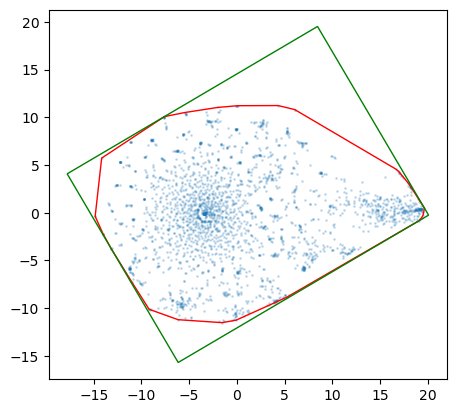

In [18]:
start = timer()
tsne = TSNE(n_components=2, perplexity=50, metric='euclidean', random_state=0, n_jobs=-1, learning_rate="auto", init='pca')
it = ImageTransformer(feature_extractor=tsne, pixels=224)
it.fit(train_rna.iloc[:, :-1], plot=True)
#save image transformer
with open("./pretrain_less_class/img_transformer_pre.obj","wb") as f:
    pickle.dump(it, f)

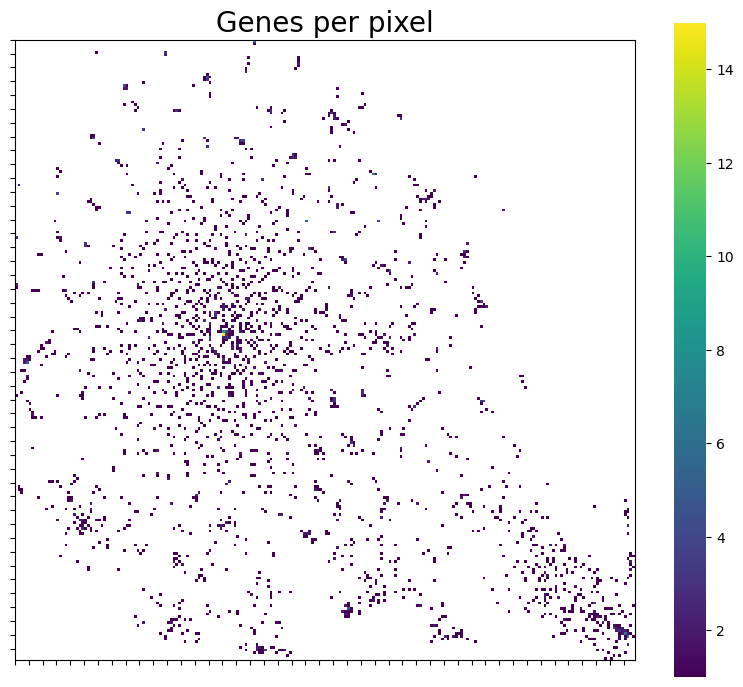

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 8.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel", fontsize = 20)

In [20]:
#Transform non-image processed datasets into images
rna_list = np.array_split(train_rna, 4)
#Split the dataset to avoid memory problems
rna1 = rna_list[0]
img_1 = (it.transform(rna1.iloc[:, :-1])*255).astype(np.uint8)
rna2 = rna_list[1]
img_2 = (it.transform(rna2.iloc[:, :-1])*255).astype(np.uint8)
rna3 = rna_list[2]
img_3 = (it.transform(rna3.iloc[:, :-1])*255).astype(np.uint8)
rna4 = rna_list[3]
img_4 = (it.transform(rna4.iloc[:, :-1])*255).astype(np.uint8)

train_img = np.concatenate((img_1, img_2, img_3, img_4), axis=0)
val_img = (it.transform(val_rna.iloc[:, :-1])*255).astype(np.uint8)
test_img = (it.transform(test_rna.iloc[:, :-1])*255).astype(np.uint8)

#Calculate the time consume in the image convertion process
end = timer()
print(end - start)

80.62227986752987


In [21]:
#Store processed images in npy format
path1 = './pretrain_less_class/train_pre.npy'
path2 = './pretrain_less_class/val_pre.npy'
path3 = './pretrain_less_class/query_pre.npy'

np.save(path1, train_img)
np.save(path2, val_img)
np.save(path3, test_img)